<a href="https://colab.research.google.com/github/gal-dmitry/HSE_RecSys/blob/master/HW_02/HW_02_PIPELINE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost==1.0.3
!pip install gensim==4.1.0
!pip install --upgrade numpy

     |████████████████████████████████| 76.3 MB 1.3 MB/s 
     |████████████████████████████████| 24.0 MB 1.7 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 15.7 MB 4.1 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.4 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
!pip install shap

     |████████████████████████████████| 564 kB 4.0 MB/s 


In [2]:
!wget https://voudy-data.s3.eu-north-1.amazonaws.com/wsdm_data.tar.gz
!tar -xf /content/wsdm_data.tar.gz

--2021-12-12 12:41:48--  https://voudy-data.s3.eu-north-1.amazonaws.com/wsdm_data.tar.gz
Resolving voudy-data.s3.eu-north-1.amazonaws.com (voudy-data.s3.eu-north-1.amazonaws.com)... 52.95.171.72
Connecting to voudy-data.s3.eu-north-1.amazonaws.com (voudy-data.s3.eu-north-1.amazonaws.com)|52.95.171.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 613394184 (585M) [application/x-gzip]
Saving to: ‘wsdm_data.tar.gz’

wsdm_data.tar.gz    100%[===================>] 584.98M  11.0MB/s    in 56s     

2021-12-12 12:42:45 (10.5 MB/s) - ‘wsdm_data.tar.gz’ saved [613394184/613394184]



In [4]:
from google.colab import files
files.upload()
files.upload()

Saving data_processing.py to data_processing.py
Saving train_utils.py to train_utils.py


Saving wikipedia-iso-country-codes.csv to wikipedia-iso-country-codes.csv


{'wikipedia-iso-country-codes.csv': b'English short name lower case,Alpha-2 code,Alpha-3 code,Numeric code,ISO 3166-2\nAfghanistan,AF,AFG,004,ISO 3166-2:AF\n\xc3\x85land Islands,AX,ALA,248,ISO 3166-2:AX\nAlbania,AL,ALB,008,ISO 3166-2:AL\nAlgeria,DZ,DZA,012,ISO 3166-2:DZ\nAmerican Samoa,AS,ASM,016,ISO 3166-2:AS\nAndorra,AD,AND,020,ISO 3166-2:AD\nAngola,AO,AGO,024,ISO 3166-2:AO\nAnguilla,AI,AIA,660,ISO 3166-2:AI\nAntarctica,AQ,ATA,010,ISO 3166-2:AQ\nAntigua and Barbuda,AG,ATG,028,ISO 3166-2:AG\nArgentina,AR,ARG,032,ISO 3166-2:AR\nArmenia,AM,ARM,051,ISO 3166-2:AM\nAruba,AW,ABW,533,ISO 3166-2:AW\nAustralia,AU,AUS,036,ISO 3166-2:AU\nAustria,AT,AUT,040,ISO 3166-2:AT\nAzerbaijan,AZ,AZE,031,ISO 3166-2:AZ\nBahamas,BS,BHS,044,ISO 3166-2:BS\nBahrain,BH,BHR,048,ISO 3166-2:BH\nBangladesh,BD,BGD,050,ISO 3166-2:BD\nBarbados,BB,BRB,052,ISO 3166-2:BB\nBelarus,BY,BLR,112,ISO 3166-2:BY\nBelgium,BE,BEL,056,ISO 3166-2:BE\nBelize,BZ,BLZ,084,ISO 3166-2:BZ\nBenin,BJ,BEN,204,ISO 3166-2:BJ\nBermuda,BM,BMU,060,I

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import pandas as pd
import numpy as np

SEED = 42

In [7]:
from train_utils import *
from data_processing import get_preprocessed_dataset

#### Dataset

Подготовка датасета. Детальное описание: [`HW_02_DATA_PREPROCESSING.ipynb`](https://github.com/gal-dmitry/HSE_RecSys/blob/master/HW_02/HW_02_DATA_PREPROCESSING.ipynb)

In [8]:
%%time
dataset = get_preprocessed_dataset(csv_folder_path=".")

process members...
process songs...
process songs extra info...
merge songs...
process train...


100%|██████████| 3/3 [00:00<00:00, 64.02it/s]


merge train...
get final dataset...
CPU times: user 1min 39s, sys: 3.46 s, total: 1min 43s
Wall time: 1min 42s


In [ ]:
### check reproducibility

# restored = pd.read_pickle("full_extended_train_df.pkl")
# assert restored.equals(dataset)
# del restored

In [11]:
# TRAIN_DATASET = TrainDataset(dataset[:1_200])
TRAIN_DATASET = TrainDataset(dataset).reduce_by_members(size=1023)

TRAIN_DATASET._df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,gender,registered_via,age_group,registration_init_year,expiration_date_year,song_length,genre_ids,artist_name,composer,lyricist,language,genre_ids_count,artist_name_count,composer_count,lyricist_count,isrc_country,isrc_year
0,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,DZanD98cLDbuPBiXONSwLFSw8BfI69ErQS23vYJ9UU4=,my library,Local playlist more,local-library,1,13,male,9,normal,2006,2017,224235,465,南拳媽媽,周杰倫,宋健彰,3.0,1,1,1,1,"Taiwan, Province of China",2008
1,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,E6Fm873UEDPv0LATidt2gKwBZZHww2Q04nxTg15N9iE=,my library,Local playlist more,local-library,1,13,male,9,normal,2006,2017,193410,465,張靚穎 (Jane Zhang),張靚穎,沈松,3.0,1,1,1,1,-1,-1
2,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,0TZ4BKn9YES2upK9ZgKgsAUtUClVKHnct79pnA/iPiQ=,my library,Local playlist more,local-library,1,13,male,9,normal,2006,2017,187199,2022,Linkin Park,FILL_NAN,FILL_NAN,52.0,1,1,0,0,United States,2003
3,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,m2YSjnhR3nzx/2WccNYpGWywohyd8fT0xR+skQC9/JQ=,my library,Local playlist more,local-library,1,13,male,9,normal,2006,2017,205635,359,Linkin Park,FILL_NAN,FILL_NAN,52.0,1,1,0,0,United States,2007
4,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,cXpk2ZXiSgkwGo8iGbswBc0lzucL9AH+j/2khmnmOLI=,my library,Local playlist more,local-playlist,0,13,male,9,normal,2006,2017,262687,2022,Starset,FILL_NAN,FILL_NAN,52.0,1,1,0,0,United States,2014


#### CatBoost

In [12]:
%%time
catboost_model = CatBoostModel(loss_function="YetiRank", 
                                 iterations=150, 
                                #  task_type="CPU",
                                 task_type="GPU",
                                 random_state=SEED)

catboost_auc_per_query = get_metric(catboost_model, TRAIN_DATASET, n_splits=5)

--- Split: 1/5 ---


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 1.35s	remaining: 3m 20s
1:	total: 2.56s	remaining: 3m 9s
2:	total: 3.77s	remaining: 3m 4s
3:	total: 4.97s	remaining: 3m 1s
4:	total: 6.18s	remaining: 2m 59s
5:	total: 7.39s	remaining: 2m 57s
6:	total: 8.6s	remaining: 2m 55s
7:	total: 9.8s	remaining: 2m 54s
8:	total: 11s	remaining: 2m 52s
9:	total: 12.2s	remaining: 2m 51s
10:	total: 13.4s	remaining: 2m 49s
11:	total: 14.6s	remaining: 2m 48s
12:	total: 15.8s	remaining: 2m 46s
13:	total: 17.1s	remaining: 2m 45s
14:	total: 18.3s	remaining: 2m 44s
15:	total: 19.5s	remaining: 2m 43s
16:	total: 20.7s	remaining: 2m 41s
17:	total: 21.9s	remaining: 2m 40s
18:	total: 23.1s	remaining: 2m 39s
19:	total: 24.3s	remaining: 2m 38s
20:	total: 25.5s	remaining: 2m 36s
21:	total: 26.7s	remaining: 2m 35s
22:	total: 27.9s	remaining: 2m 34s
23:	total: 29.2s	remaining: 2m 33s
24:	total: 30.4s	remaining: 2m 31s
25:	total: 31.6s	remaining: 2m 30s
26:	total: 32.8s	remaining: 2m 29s
27:	total: 34s	remaining: 2m 28s
28:	total: 35.2s	remaining: 2m 26s
29:	

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 1.35s	remaining: 3m 21s
1:	total: 2.55s	remaining: 3m 9s
2:	total: 3.76s	remaining: 3m 4s
3:	total: 4.96s	remaining: 3m 1s
4:	total: 6.17s	remaining: 2m 58s
5:	total: 7.37s	remaining: 2m 56s
6:	total: 8.58s	remaining: 2m 55s
7:	total: 9.79s	remaining: 2m 53s
8:	total: 11s	remaining: 2m 52s
9:	total: 12.2s	remaining: 2m 51s
10:	total: 13.4s	remaining: 2m 49s
11:	total: 14.6s	remaining: 2m 48s
12:	total: 15.8s	remaining: 2m 46s
13:	total: 17s	remaining: 2m 45s
14:	total: 18.2s	remaining: 2m 44s
15:	total: 19.5s	remaining: 2m 42s
16:	total: 20.7s	remaining: 2m 41s
17:	total: 21.9s	remaining: 2m 40s
18:	total: 23.1s	remaining: 2m 39s
19:	total: 24.3s	remaining: 2m 37s
20:	total: 25.5s	remaining: 2m 36s
21:	total: 26.7s	remaining: 2m 35s
22:	total: 27.9s	remaining: 2m 34s
23:	total: 29.1s	remaining: 2m 32s
24:	total: 30.3s	remaining: 2m 31s
25:	total: 31.5s	remaining: 2m 30s
26:	total: 32.8s	remaining: 2m 29s
27:	total: 34s	remaining: 2m 27s
28:	total: 35.2s	remaining: 2m 26s
29:	

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 1.36s	remaining: 3m 23s
1:	total: 2.57s	remaining: 3m 10s
2:	total: 3.77s	remaining: 3m 4s
3:	total: 4.97s	remaining: 3m 1s
4:	total: 6.17s	remaining: 2m 58s
5:	total: 7.36s	remaining: 2m 56s
6:	total: 8.58s	remaining: 2m 55s
7:	total: 9.78s	remaining: 2m 53s
8:	total: 11s	remaining: 2m 52s
9:	total: 12.2s	remaining: 2m 50s
10:	total: 13.4s	remaining: 2m 49s
11:	total: 14.6s	remaining: 2m 47s
12:	total: 15.8s	remaining: 2m 46s
13:	total: 17s	remaining: 2m 45s
14:	total: 18.2s	remaining: 2m 43s
15:	total: 19.4s	remaining: 2m 42s
16:	total: 20.6s	remaining: 2m 41s
17:	total: 21.8s	remaining: 2m 40s
18:	total: 23s	remaining: 2m 38s
19:	total: 24.2s	remaining: 2m 37s
20:	total: 25.4s	remaining: 2m 36s
21:	total: 26.6s	remaining: 2m 35s
22:	total: 27.8s	remaining: 2m 33s
23:	total: 29.1s	remaining: 2m 32s
24:	total: 30.3s	remaining: 2m 31s
25:	total: 31.5s	remaining: 2m 30s
26:	total: 32.7s	remaining: 2m 28s
27:	total: 33.9s	remaining: 2m 27s
28:	total: 35.1s	remaining: 2m 26s
29:

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 1.37s	remaining: 3m 24s
1:	total: 2.58s	remaining: 3m 11s
2:	total: 3.79s	remaining: 3m 5s
3:	total: 5s	remaining: 3m 2s
4:	total: 6.21s	remaining: 3m
5:	total: 7.42s	remaining: 2m 58s
6:	total: 8.63s	remaining: 2m 56s
7:	total: 9.85s	remaining: 2m 54s
8:	total: 11.1s	remaining: 2m 53s
9:	total: 12.3s	remaining: 2m 51s
10:	total: 13.5s	remaining: 2m 50s
11:	total: 14.7s	remaining: 2m 48s
12:	total: 15.9s	remaining: 2m 47s
13:	total: 17.1s	remaining: 2m 46s
14:	total: 18.3s	remaining: 2m 44s
15:	total: 19.5s	remaining: 2m 43s
16:	total: 20.7s	remaining: 2m 42s
17:	total: 22s	remaining: 2m 41s
18:	total: 23.2s	remaining: 2m 39s
19:	total: 24.4s	remaining: 2m 38s
20:	total: 25.6s	remaining: 2m 37s
21:	total: 26.8s	remaining: 2m 36s
22:	total: 28s	remaining: 2m 34s
23:	total: 29.3s	remaining: 2m 33s
24:	total: 30.5s	remaining: 2m 32s
25:	total: 31.7s	remaining: 2m 31s
26:	total: 32.9s	remaining: 2m 29s
27:	total: 34.1s	remaining: 2m 28s
28:	total: 35.4s	remaining: 2m 27s
29:	tota

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 1.38s	remaining: 3m 25s
1:	total: 2.58s	remaining: 3m 11s
2:	total: 3.81s	remaining: 3m 6s
3:	total: 5.03s	remaining: 3m 3s
4:	total: 6.24s	remaining: 3m 1s
5:	total: 7.46s	remaining: 2m 59s
6:	total: 8.68s	remaining: 2m 57s
7:	total: 9.89s	remaining: 2m 55s
8:	total: 11.1s	remaining: 2m 54s
9:	total: 12.3s	remaining: 2m 52s
10:	total: 13.6s	remaining: 2m 51s
11:	total: 14.8s	remaining: 2m 49s
12:	total: 16s	remaining: 2m 48s
13:	total: 17.2s	remaining: 2m 47s
14:	total: 18.4s	remaining: 2m 45s
15:	total: 19.7s	remaining: 2m 44s
16:	total: 20.9s	remaining: 2m 43s
17:	total: 22.1s	remaining: 2m 42s
18:	total: 23.3s	remaining: 2m 40s
19:	total: 24.5s	remaining: 2m 39s
20:	total: 25.8s	remaining: 2m 38s
21:	total: 27s	remaining: 2m 36s
22:	total: 28.2s	remaining: 2m 35s
23:	total: 29.4s	remaining: 2m 34s
24:	total: 30.7s	remaining: 2m 33s
25:	total: 31.9s	remaining: 2m 32s
26:	total: 33.1s	remaining: 2m 30s
27:	total: 34.3s	remaining: 2m 29s
28:	total: 35.5s	remaining: 2m 28s
29

In [13]:
catboost_auc_per_query

,AUC_per_query
split: 1,0.639934
split: 2,0.640393
split: 3,0.641983
split: 4,0.642495
split: 5,0.64141
avg,0.641243


#### Embeddings

In [14]:
%%time
embedding_model = EmbeddingModel(embedding_dim=100, 
                                 random_state=SEED, 
                                #  min_count=1)
                                 min_count=5)

embedding_auc_per_query = get_metric(embedding_model, TRAIN_DATASET, n_splits=5)

--- Split: 1/5 ---
Fit items...


Fit users: 100%|██████████| 30755/30755 [15:25<00:00, 33.24it/s]


--- Split: 2/5 ---
Fit items...


Fit users: 100%|██████████| 30755/30755 [14:50<00:00, 34.53it/s]


--- Split: 3/5 ---
Fit items...


Fit users: 100%|██████████| 30755/30755 [14:40<00:00, 34.94it/s]


--- Split: 4/5 ---
Fit items...


Fit users: 100%|██████████| 30755/30755 [14:52<00:00, 34.47it/s]


--- Split: 5/5 ---
Fit items...


Fit users: 100%|██████████| 30755/30755 [14:45<00:00, 34.72it/s]


CPU times: user 1h 32min 3s, sys: 1min 9s, total: 1h 33min 13s
Wall time: 1h 25min 46s


In [15]:
embedding_auc_per_query

,AUC_per_query
split: 1,0.5
split: 2,0.5
split: 3,0.5
split: 4,0.5
split: 5,0.5
avg,0.5


#### Embeddings + CatBoost

In [16]:
%%time
stack_model = StackModel(loss_function="YetiRank", 
                         iterations=150, 
                        #  task_type="CPU",
                         task_type="GPU",  
                         random_state=SEED,
                         embedding_dim=100,
                        #  min_count=1)
                         min_count=5)

stack_scores = get_metric(stack_model, TRAIN_DATASET, n_splits=5)

--- Split: 1/5 ---
Fit items...


KeyboardInterrupt: ignored

In [ ]:
stack_scores

#### Shapley values

In [15]:
%%time
# shap_class = ShapValues(min_count=1)
shap_class = ShapValues(min_count=5)
shap_class.fit(TRAIN_DATASET, 
            #    split=0.2)
               split=1000)

Train size: 200 | Test size: 1000
Fit items...


Fit users: 100%|██████████| 30755/30755 [00:00<00:00, 112243.58it/s]


Groupwise loss function. OneHotMaxSize set to 10
0:	total: 3.97ms	remaining: 592ms
1:	total: 6.89ms	remaining: 510ms
2:	total: 9.98ms	remaining: 489ms
3:	total: 13.7ms	remaining: 499ms
4:	total: 17.6ms	remaining: 510ms
5:	total: 20.4ms	remaining: 489ms
6:	total: 23.2ms	remaining: 474ms
7:	total: 26.1ms	remaining: 464ms
8:	total: 29ms	remaining: 455ms
9:	total: 36.9ms	remaining: 517ms
10:	total: 40ms	remaining: 505ms
11:	total: 42.9ms	remaining: 493ms
12:	total: 45.7ms	remaining: 481ms
13:	total: 48.4ms	remaining: 470ms
14:	total: 51.2ms	remaining: 461ms
15:	total: 54ms	remaining: 452ms
16:	total: 56.8ms	remaining: 445ms
17:	total: 59.9ms	remaining: 440ms
18:	total: 62.7ms	remaining: 433ms
19:	total: 65.5ms	remaining: 426ms
20:	total: 68.3ms	remaining: 420ms
21:	total: 71.2ms	remaining: 414ms
22:	total: 73.9ms	remaining: 408ms
23:	total: 77ms	remaining: 404ms
24:	total: 80.2ms	remaining: 401ms
25:	total: 82.8ms	remaining: 395ms
26:	total: 85.6ms	remaining: 390ms
27:	total: 88.5ms	remain

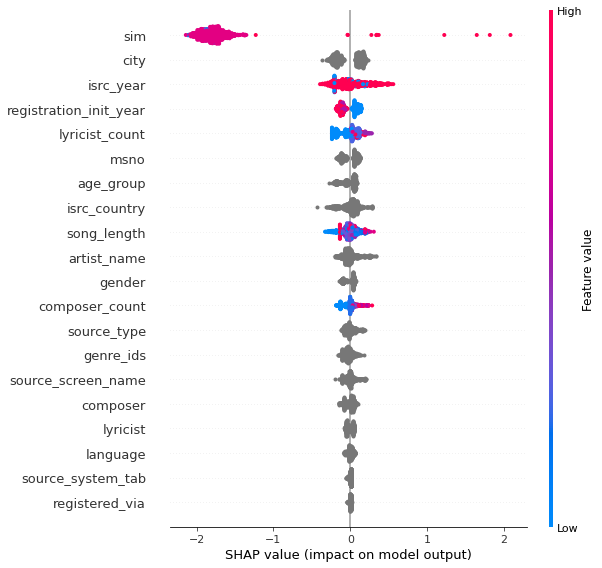

In [16]:
shap_class.show_shap_values()